In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix

In [5]:
city = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/Cities.csv')
conference = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/Conferences.csv')
tourneygame = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MConferenceTourneyGames.csv')
gamecity = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MGameCities.csv')
ordinals = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MMasseyOrdinals.csv')
t_compact_result = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneyCompactResults.csv')
t_detailed_result = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneyDetailedResults.csv')
seed_round_slots = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySeedRoundSlots.csv')
seed = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySeeds.csv')
slots = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MNCAATourneySlots.csv')
reg_sea_comp_results = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MRegularSeasonCompactResults.csv')
reg_sea_detail_results = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MRegularSeasonDetailedResults.csv')
sample_subm_s1 = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MSampleSubmissionStage1.csv')
season = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MSeasons.csv')
second_t_comp_result = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MSecondaryTourneyCompactResults.csv')
second_t_teams= pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MSecondaryTourneyTeams.csv')
coaches = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MTeamCoaches.csv')
team_conference = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MTeamConferences.csv')
team = pd.read_csv('mens-march-mania-2022/MDataFiles_Stage1/MTeams.csv')

In [6]:
reg_sea_detail_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14


In [7]:
team.head()

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2022
1,1102,Air Force,1985,2022
2,1103,Akron,1985,2022
3,1104,Alabama,1985,2022
4,1105,Alabama A&M,2000,2022


In [8]:
reg_sea_detail_results.shape

(100423, 34)

## Get season averages

In [14]:
df_season_train = reg_sea_detail_results[reg_sea_detail_results['Season'] < 2016]
w_columns = [col for col in df_season_train.columns if col.startswith('W') or col == 'Season']
selected_df_w = df_season_train.loc[:, w_columns]
renamed_df_w = selected_df_w.rename(columns=lambda x: x.replace('W', ''))
l_columns = [col for col in df_season_train.columns if col.startswith('L') or col == 'Season']
selected_df_l = df_season_train.loc[:, l_columns]
renamed_df_l = selected_df_l.rename(columns=lambda x: x.replace('L', ''))
stacked_df = pd.concat([renamed_df_w, renamed_df_l], axis=0, ignore_index=True)
stacked_df.drop('Loc', axis=1, inplace=True)

In [15]:
stacked_df.head()

,Season,TeamID,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1104,68,27,58,3,14,11,18,14,24,13,23,7,1,22
1,2003,1272,70,26,62,8,20,10,19,15,28,16,13,4,4,18
2,2003,1266,73,24,58,8,18,17,29,17,26,15,10,5,2,25
3,2003,1296,56,18,38,3,9,17,31,6,19,11,12,14,2,18
4,2003,1400,77,30,61,6,14,11,13,17,22,12,14,4,4,20


In [16]:
df_season_avg = stacked_df.groupby(['Season','TeamID']).mean()

In [17]:
df_season_avg.head()

Score        FGM        FGA      FGM3       FGA3  \
Season TeamID                                                         
2003   1102    57.250000  19.142857  39.785714  7.821429  20.821429   
       1103    78.777778  27.148148  55.851852  5.444444  16.074074   
       1104    69.285714  24.035714  57.178571  6.357143  19.857143   
       1105    71.769231  24.384615  61.615385  7.576923  20.769231   
       1106    63.607143  23.428571  55.285714  6.107143  17.642857   

                     FTM        FTA         OR         DR        Ast  \
Season TeamID                                                          
2003   1102    11.142857  17.107143   4.178571  16.821429  13.000000   
       1103    19.037037  25.851852   9.777778  19.925926  15.222222   
       1104    14.857143  20.928571  13.571429  23.928571  12.107143   
       1105    15.423077  21.846154  13.500000  23.115385  14.538462   
       1106    10.642857  16.464286  12.285714  23.857143  11.678571   

                      TO       Stl       Blk         PF  
Season TeamID                                            
2003   1102    11.428571  5.964286  1.785714  18.750000  
       1103    12.629630  7.259259  2.333333  19.851852  
       1104    13.285714  6.607143  3.785714  18.035714  
       1105    18.653846  9.307692  2.076923  20.230769  
       1106    17.035714  8.357143  3.142857  18.178571

## Get Tournament Results

In [18]:
df_tourney = t_compact_result[t_compact_result['Season'] < 2016]

In [19]:
df_tourney.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


In [20]:
df_tourney.WLoc.value_counts()

WLoc
N    1983
Name: count, dtype: int64

In [21]:
df_tourney_1 = df_tourney.loc[:,['Season', 'WTeamID','LTeamID', 'WScore', 'LScore']]
df_tourney_1.columns = ['Season', 'T1ID','T2ID','T1Score','T2Score']
df_tourney_2 = df_tourney.loc[:,['Season', 'LTeamID','WTeamID', 'LScore', 'WScore']]
df_tourney_2.columns = ['Season', 'T1ID','T2ID','T1Score','T2Score']
df_tourney_new = pd.concat([df_tourney_1, df_tourney_2], axis=0, ignore_index=True)

In [22]:
df_tourney_new.head()

,Season,T1ID,T2ID,T1Score,T2Score
0,1985,1116,1234,63,54
1,1985,1120,1345,59,58
2,1985,1207,1250,68,43
3,1985,1229,1425,58,55
4,1985,1242,1325,49,38


In [23]:
df_tourney_new['outcome'] = np.where(df_tourney_new['T1Score'] > df_tourney_new['T2Score'], 1, 0)

In [24]:
df_tourney_new.head()

,Season,T1ID,T2ID,T1Score,T2Score,outcome
0,1985,1116,1234,63,54,1
1,1985,1120,1345,59,58,1
2,1985,1207,1250,68,43,1
3,1985,1229,1425,58,55,1
4,1985,1242,1325,49,38,1


## Combine dependent variable with independent variables

In [25]:
merged_df = df_tourney_new.merge(df_season_avg, left_on=['Season', 'T1ID'], right_on=['Season', 'TeamID'], how = 'inner')
merged_df = merged_df.merge(df_season_avg, left_on=['Season', 'T2ID'], right_on=['Season', 'TeamID'], how = 'inner', suffixes=('_T1', '_T2'))

In [26]:
merged_df.shape

(1694, 34)

In [27]:
merged_df.head()

,Season,T1ID,T2ID,T1Score,T2Score,outcome,Score_T1,FGM_T1,FGA_T1,FGM3_T1,...,FGA3_T2,FTM_T2,FTA_T2,OR_T2,DR_T2,Ast_T2,TO_T2,Stl_T2,Blk_T2,PF_T2
0,2003,1421,1411,92,84,1,71.206897,24.379310,56.793103,6.482759,...,18.500000,17.400000,28.066667,13.166667,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000
1,2003,1112,1436,80,51,1,85.214286,30.321429,65.714286,7.035714,...,15.482759,12.862069,19.551724,12.965517,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552
2,2003,1113,1272,84,71,1,75.965517,27.206897,56.896552,4.000000,...,20.068966,14.965517,22.896552,14.068966,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621
3,2003,1141,1166,79,73,1,79.344828,26.620690,52.689655,6.827586,...,20.484848,13.878788,20.030303,10.878788,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727
4,2003,1143,1301,76,74,1,74.482759,27.344828,58.724138,6.413793,...,22.500000,15.766667,20.466667,9.733333,22.033333,14.666667,14.200000,7.766667,3.066667,18.666667


In [28]:
seed.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [29]:
merged_df = merged_df.merge(seed, left_on=['Season', 'T1ID'], right_on=['Season', 'TeamID'], how = 'inner')
merged_df = merged_df.merge(seed, left_on=['Season', 'T2ID'], right_on=['Season', 'TeamID'], how = 'inner', suffixes=('_T1', '_T2'))
merged_df.drop(['TeamID_T1','TeamID_T2'], axis = 1, inplace= True)

In [30]:
coaches.head()

,Season,TeamID,FirstDayNum,LastDayNum,CoachName
0,1985,1102,0,154,reggie_minton
1,1985,1103,0,154,bob_huggins
2,1985,1104,0,154,wimp_sanderson
3,1985,1106,0,154,james_oliver
4,1985,1108,0,154,davey_whitney


In [31]:
merged_df = merged_df.merge(coaches, left_on=['Season', 'T1ID'], right_on=['Season', 'TeamID'], how = 'inner')
merged_df = merged_df.merge(coaches, left_on=['Season', 'T2ID'], right_on=['Season', 'TeamID'], how = 'inner', suffixes=('_T1', '_T2'))

In [32]:
merged_df.head()

,Season,T1ID,T2ID,T1Score,T2Score,outcome,Score_T1,FGM_T1,FGA_T1,FGM3_T1,...,Seed_T1,Seed_T2,TeamID_T1,FirstDayNum_T1,LastDayNum_T1,CoachName_T1,TeamID_T2,FirstDayNum_T2,LastDayNum_T2,CoachName_T2
0,2003,1421,1411,92,84,1,71.206897,24.379310,56.793103,6.482759,...,X16b,X16a,1421,0,154,eddie_biedenbach,1411,0,154,ronnie_courtney
1,2003,1112,1436,80,51,1,85.214286,30.321429,65.714286,7.035714,...,Z01,Z16,1112,0,154,lute_olson,1436,0,154,tom_brennan
2,2003,1113,1272,84,71,1,75.965517,27.206897,56.896552,4.000000,...,Z10,Z07,1113,0,154,rob_evans,1272,0,154,john_calipari
3,2003,1141,1166,79,73,1,79.344828,26.620690,52.689655,6.827586,...,Z11,Z06,1141,0,154,jay_smith,1166,0,154,dana_altman
4,2003,1143,1301,76,74,1,74.482759,27.344828,58.724138,6.413793,...,W08,W09,1143,0,154,ben_braun,1301,0,154,herb_sendek


In [33]:
merged_df.drop(['TeamID_T1','TeamID_T2','FirstDayNum_T1','FirstDayNum_T2', 'LastDayNum_T1', 'LastDayNum_T2'], axis = 1, inplace= True)

In [34]:
merged_df.shape

(1702, 38)

In [35]:
merged_df.head()

,Season,T1ID,T2ID,T1Score,T2Score,outcome,Score_T1,FGM_T1,FGA_T1,FGM3_T1,...,DR_T2,Ast_T2,TO_T2,Stl_T2,Blk_T2,PF_T2,Seed_T1,Seed_T2,CoachName_T1,CoachName_T2
0,2003,1421,1411,92,84,1,71.206897,24.379310,56.793103,6.482759,...,24.800000,14.200000,15.233333,6.433333,2.233333,18.300000,X16b,X16a,eddie_biedenbach,ronnie_courtney
1,2003,1112,1436,80,51,1,85.214286,30.321429,65.714286,7.035714,...,25.724138,14.206897,14.068966,6.862069,2.965517,15.896552,Z01,Z16,lute_olson,tom_brennan
2,2003,1113,1272,84,71,1,75.965517,27.206897,56.896552,4.000000,...,25.965517,16.620690,13.793103,7.379310,5.068966,18.758621,Z10,Z07,rob_evans,john_calipari
3,2003,1141,1166,79,73,1,79.344828,26.620690,52.689655,6.827586,...,23.181818,16.818182,13.363636,8.393939,4.454545,17.272727,Z11,Z06,jay_smith,dana_altman
4,2003,1143,1301,76,74,1,74.482759,27.344828,58.724138,6.413793,...,22.033333,14.666667,14.200000,7.766667,3.066667,18.666667,W08,W09,ben_braun,herb_sendek


## EDA

In [36]:
merged_df.iloc[:, 5:34].groupby(['outcome']).mean()

,Score_T1,FGM_T1,FGA_T1,FGM3_T1,FGA3_T1,FTM_T1,FTA_T1,OR_T1,DR_T1,Ast_T1,...,FGA3_T2,FTM_T2,FTA_T2,OR_T2,DR_T2,Ast_T2,TO_T2,Stl_T2,Blk_T2,PF_T2
outcome,,,,,,,,,,,,,,,,,,,,,
0,72.910553,25.534779,55.859824,6.614990,18.355052,15.226006,21.623353,11.652158,24.318878,14.361975,...,18.313019,15.329206,21.749336,12.112301,24.697301,14.842648,12.695178,7.213807,4.303093,17.404254
1,74.647560,26.330390,56.796769,6.657574,18.313019,15.329206,21.749336,12.112301,24.697301,14.842648,...,18.355052,15.226006,21.623353,11.652158,24.318878,14.361975,13.045244,7.025428,3.858908,17.808410


In [37]:
def categorize(seed):
    seed_n = int(seed[1:3])
    if seed_n < 4:
        return '0-4'
    elif seed_n < 9:
        return '5-8'
    elif seed_n < 12:
        return '9-12'
    else:
        return '13-16'
    

In [38]:
int('W10'[1:3])

10

In [39]:
categorize('W10')

'9-12'

In [40]:
merged_df['New_seed_T1'] = merged_df['Seed_T1'].apply(categorize)
merged_df['New_seed_T2'] = merged_df['Seed_T2'].apply(categorize)

In [41]:
merged_df.head()

,Season,T1ID,T2ID,T1Score,T2Score,outcome,Score_T1,FGM_T1,FGA_T1,FGM3_T1,...,TO_T2,Stl_T2,Blk_T2,PF_T2,Seed_T1,Seed_T2,CoachName_T1,CoachName_T2,New_seed_T1,New_seed_T2
0,2003,1421,1411,92,84,1,71.206897,24.379310,56.793103,6.482759,...,15.233333,6.433333,2.233333,18.300000,X16b,X16a,eddie_biedenbach,ronnie_courtney,13-16,13-16
1,2003,1112,1436,80,51,1,85.214286,30.321429,65.714286,7.035714,...,14.068966,6.862069,2.965517,15.896552,Z01,Z16,lute_olson,tom_brennan,0-4,13-16
2,2003,1113,1272,84,71,1,75.965517,27.206897,56.896552,4.000000,...,13.793103,7.379310,5.068966,18.758621,Z10,Z07,rob_evans,john_calipari,9-12,5-8
3,2003,1141,1166,79,73,1,79.344828,26.620690,52.689655,6.827586,...,13.363636,8.393939,4.454545,17.272727,Z11,Z06,jay_smith,dana_altman,9-12,5-8
4,2003,1143,1301,76,74,1,74.482759,27.344828,58.724138,6.413793,...,14.200000,7.766667,3.066667,18.666667,W08,W09,ben_braun,herb_sendek,5-8,9-12


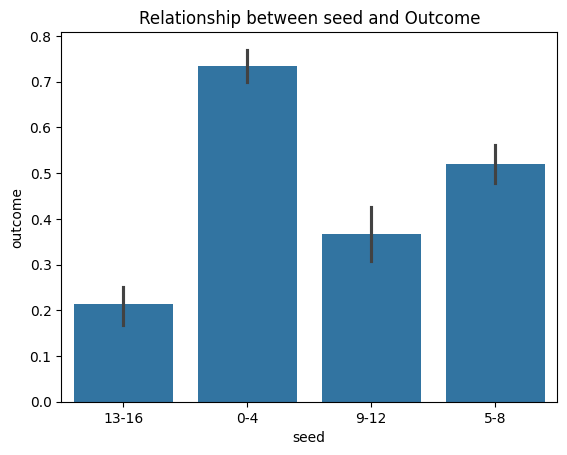

In [42]:
sns.barplot(x = merged_df['New_seed_T1'], y = merged_df['outcome'])
plt.ylabel('outcome')
plt.xlabel('seed')
plt.title('Relationship between seed and Outcome')

plt.show()

In [43]:
df = pd.get_dummies(merged_df, columns=['New_seed_T1','New_seed_T2'])

In [44]:
df.head()

,Season,T1ID,T2ID,T1Score,T2Score,outcome,Score_T1,FGM_T1,FGA_T1,FGM3_T1,...,CoachName_T1,CoachName_T2,New_seed_T1_0-4,New_seed_T1_13-16,New_seed_T1_5-8,New_seed_T1_9-12,New_seed_T2_0-4,New_seed_T2_13-16,New_seed_T2_5-8,New_seed_T2_9-12
0,2003,1421,1411,92,84,1,71.206897,24.379310,56.793103,6.482759,...,eddie_biedenbach,ronnie_courtney,False,True,False,False,False,True,False,False
1,2003,1112,1436,80,51,1,85.214286,30.321429,65.714286,7.035714,...,lute_olson,tom_brennan,True,False,False,False,False,True,False,False
2,2003,1113,1272,84,71,1,75.965517,27.206897,56.896552,4.000000,...,rob_evans,john_calipari,False,False,False,True,False,False,True,False
3,2003,1141,1166,79,73,1,79.344828,26.620690,52.689655,6.827586,...,jay_smith,dana_altman,False,False,False,True,False,False,True,False
4,2003,1143,1301,76,74,1,74.482759,27.344828,58.724138,6.413793,...,ben_braun,herb_sendek,False,False,True,False,False,False,False,True


In [45]:
training = df.iloc[:, 5::]
x_train = training.drop(['outcome','Seed_T1','Seed_T2','CoachName_T1','CoachName_T2'], axis=1)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_train)
y_train = training['outcome']
logreg = LogisticRegression(random_state=1, max_iter = 600)
logreg.fit(x_scaled, y_train)
y_pred = logreg.predict(x_scaled)
accuracy = accuracy_score(y_train, y_pred)
print(f'In-Sample Accruacy:{accuracy:.3f}')
scores = cross_val_score(logreg, x_scaled, y_train, cv=5)
mean_score = np.mean(scores)
std_dev = np.std(scores)
print(f'Mean Score: {mean_score:.3f}')
print(f'Std Dev: {std_dev:.3f}')

In-Sample Accruacy:0.709
Mean Score: 0.696
Std Dev: 0.027


In [112]:
training = df.iloc[:, 5::]
x_train = training.drop(['outcome','Seed_T1','Seed_T2','CoachName_T1','CoachName_T2'], axis=1)
y_train = training['outcome']
dt_model = DecisionTreeClassifier(random_state=1)
dt_model.fit(x_train, y_train)
scores = cross_val_score(dt_model, x_train, y_train, cv=5)
mean_score = np.mean(scores)
std_dev = np.std(scores)
print(f'Mean Score: {mean_score:.3f}')
print(f'Std Dev: {std_dev:.3f}')

Mean Score: 0.623
Std Dev: 0.041


In [113]:
training = df.iloc[:, 5::]
x_train = training.drop(['outcome','Seed_T1','Seed_T2','CoachName_T1','CoachName_T2'], axis=1)
y_train = training['outcome']
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(x_train, y_train)
scores = cross_val_score(rf_model, x_train, y_train, cv=5)
mean_score = np.mean(scores)
std_dev = np.std(scores)
print(f'Mean Score: {mean_score:.3f}')
print(f'Std Dev: {std_dev:.3f}')

Mean Score: 0.676
Std Dev: 0.035


In [114]:
training = df.iloc[:, 5::]
x_train = training.drop(['outcome','Seed_T1','Seed_T2','CoachName_T1','CoachName_T2'], axis=1)
y_train = training['outcome']
xgb_model = xgb.XGBClassifier(random_state=1)
xgb_model.fit(x_train, y_train)
scores = cross_val_score(xgb_model, x_train, y_train, cv=5)
mean_score = np.mean(scores)
std_dev = np.std(scores)
print(f'Mean Score: {mean_score:.3f}')
print(f'Std Dev: {std_dev:.3f}')

Mean Score: 0.671
Std Dev: 0.027


## Finetuning Logistic Regression

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.1, 0.5, 1, 5, 10]}
model = LogisticRegression(random_state = 1, max_iter = 600)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_train, y_train)
grid_search.cv_results_

{'mean_fit_time': array([0.0644887 , 0.03408761, 0.06459208, 0.04676981, 0.06300764]),
 'std_fit_time': array([0.07838847, 0.00839171, 0.0426186 , 0.01238469, 0.02637905]),
 'mean_score_time': array([0.00110707, 0.00169182, 0.00157094, 0.00218425, 0.00183182]),
 'std_score_time': array([0.00020036, 0.00097628, 0.00070352, 0.00138525, 0.00115515]),
 'param_C': masked_array(data=[0.1, 0.5, 1, 5, 10],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1}, {'C': 0.5}, {'C': 1}, {'C': 5}, {'C': 10}],
 'split0_test_score': array([0.7126075 , 0.71847265, 0.71847265, 0.71847265, 0.71847265]),
 'split1_test_score': array([0.72727273, 0.71847265, 0.71847265, 0.71847265, 0.71847265]),
 'split2_test_score': array([0.67647059, 0.68235294, 0.67647059, 0.67647059, 0.67647059]),
 'split3_test_score': array([0.66470588, 0.65294118, 0.64705882, 0.64705882, 0.64705882]),
 'split4_test_score': array([0.70588235, 0.72352941, 0.717

In [116]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {'C': [0.4, 0.45, 0.5, 0.55, 0.6]}
model = LogisticRegression(random_state = 1, max_iter = 600)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(x_train, y_train)
grid_search.cv_results_

{'mean_fit_time': array([0.07760739, 0.0295887 , 0.05849557, 0.07730227, 0.04339781]),
 'std_fit_time': array([0.03211246, 0.01557921, 0.03154568, 0.02655078, 0.01198193]),
 'mean_score_time': array([0.00291457, 0.00130658, 0.0014832 , 0.00152617, 0.00147152]),
 'std_score_time': array([0.0012118 , 0.00079211, 0.00061515, 0.00040125, 0.00109728]),
 'param_C': masked_array(data=[0.4, 0.45, 0.5, 0.55, 0.6],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.4}, {'C': 0.45}, {'C': 0.5}, {'C': 0.55}, {'C': 0.6}],
 'split0_test_score': array([0.71847265, 0.71847265, 0.71847265, 0.71847265, 0.71847265]),
 'split1_test_score': array([0.71847265, 0.71847265, 0.71847265, 0.71847265, 0.71847265]),
 'split2_test_score': array([0.67647059, 0.68235294, 0.68235294, 0.68235294, 0.68235294]),
 'split3_test_score': array([0.65294118, 0.65294118, 0.65294118, 0.65294118, 0.65294118]),
 'split4_test_score': array([0.72941176, 0.7

## Test Data

In [46]:
df_season_test = reg_sea_detail_results[reg_sea_detail_results['Season'] == 2017]
w_columns_test = [col for col in df_season_test.columns if col.startswith('W') or col == 'Season']
selected_df_w_test = df_season_test.loc[:, w_columns_test]
renamed_df_w_test = selected_df_w_test.rename(columns=lambda x: x.replace('W', ''))
l_columns_test = [col for col in df_season_test.columns if col.startswith('L') or col == 'Season']
selected_df_l_test = df_season_test.loc[:, l_columns_test]
renamed_df_l_test = selected_df_l_test.rename(columns=lambda x: x.replace('L', ''))
stacked_df_test = pd.concat([renamed_df_w_test, renamed_df_l_test], axis=0, ignore_index=True)
stacked_df_test.drop('Loc', axis=1, inplace=True)
df_season_avg_test = stacked_df_test.groupby(['Season','TeamID']).mean()
df_tourney_test = t_compact_result[t_compact_result['Season'] == 2017]
df_tourney_1_test = df_tourney_test.loc[:,['Season', 'WTeamID','LTeamID', 'WScore', 'LScore']]
df_tourney_1_test.columns = ['Season', 'T1ID','T2ID','T1Score','T2Score']
df_tourney_2_test = df_tourney_test.loc[:,['Season', 'LTeamID','WTeamID', 'LScore', 'WScore']]
df_tourney_2_test.columns = ['Season', 'T1ID','T2ID','T1Score','T2Score']
df_tourney_test_new = pd.concat([df_tourney_1_test, df_tourney_2_test], axis=0, ignore_index=True)
df_tourney_test_new['outcome'] = np.where(df_tourney_test_new['T1Score'] > df_tourney_test_new['T2Score'], 1, 0)
merged_df_test = df_tourney_test_new.merge(df_season_avg_test, left_on=['Season', 'T1ID'], right_on=['Season', 'TeamID'], how = 'inner')
merged_df_test = merged_df_test.merge(df_season_avg_test, left_on=['Season', 'T2ID'], right_on=['Season', 'TeamID'], how = 'inner', suffixes=('_T1', '_T2'))
merged_df_test = merged_df_test.merge(seed, left_on=['Season', 'T1ID'], right_on=['Season', 'TeamID'], how = 'inner')
merged_df_test = merged_df_test.merge(seed, left_on=['Season', 'T2ID'], right_on=['Season', 'TeamID'], how = 'inner', suffixes=('_T1', '_T2'))
merged_df_test.drop(['TeamID_T1','TeamID_T2'], axis = 1, inplace= True)
merged_df_test['New_seed_T1'] = merged_df_test['Seed_T1'].apply(categorize)
merged_df_test['New_seed_T2'] = merged_df_test['Seed_T2'].apply(categorize)
df_test = pd.get_dummies(merged_df_test, columns=['New_seed_T1','New_seed_T2'])

In [47]:
training = df.iloc[:, 5::]
test = df_test.iloc[:,5::]
x_train = training.drop(['outcome','Seed_T1','Seed_T2','CoachName_T1','CoachName_T2'], axis=1)
x_test = test.drop(['outcome','Seed_T1','Seed_T2'], axis=1)
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
scaler = StandardScaler()
x_test_scaled = scaler.fit_transform(x_test)
y_test = test['outcome']
logreg = LogisticRegression(random_state=1, max_iter = 600, C = 0.05)
logreg.fit(x_scaled, y_train)
y_pred = logreg.predict(x_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f'Out-Sample Accruacy:{accuracy:.3f}')
cf_mat = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(cf_mat)

Out-Sample Accruacy:0.701
Confusion matrix
[[47 20]
 [20 47]]


In [48]:
pred = logreg.predict_proba(x_test_scaled)[:, 1]
auc = roc_auc_score(y_test, pred)
print(f"AUC Score: {auc:.3f}")

AUC Score: 0.801


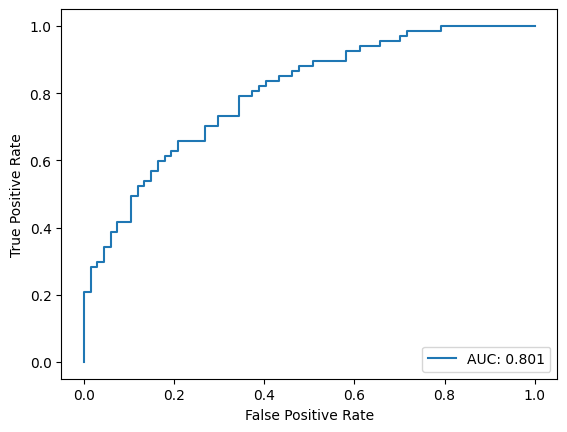

In [49]:
fig, ax = plt.subplots()
fpr, tpr, _ = roc_curve(y_test, pred)
ax.plot(fpr, tpr, label=f"AUC: {auc:.3f}")
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')
plt.show()